## Imports

In [1]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from scipy.ndimage.measurements import label
from sklearn.externals import joblib

## Retrieve Images

In [17]:
def getImageFilesFromDirectory(directories):
    images = []
    for directory in directories:
        for imageFile in os.listdir(directory):
            if not imageFile[0] == '.':
                images.append(directory + '/' + imageFile)   
    return images

def displayImages(images):
    if len(images) == 1:
        showImage(images[0],plt)
        return
    
    plt.figure
    f, axarr = plt.subplots(1,len(images))
    for i in range(len(images)):
        showImage(images[i],axarr[i],multiple=True)
        
def showImage(image,obj,multiple=False):
    if not multiple:
        obj.figure()
    if len(image.shape) == 2: 
        color='gray'
    else:
        color=None
    obj.imshow(image, cmap=color)

In [3]:
image = mpimg.imread('training_data/vehicles/KITTI_extracted/1.png')
print('Train image shape: ',image.shape)

Train image shape:  (64, 64, 3)


## Feature Parameters

In [4]:
class featureParams():
    def __init__(self):
        # HOG
        self.channel = 2
        self.orient = 9
        self.pix_per_cell = 9
        self.cell_per_block = 2
        
        # color spatial
        self.colorSpace = 'HSV'
        self.spatial_size = (32, 32)
        
        # color histogram
        self.hist_bins = 32
        self.hist_range = (0,256)
    
params = featureParams()

## HOG

In [5]:
def HOGfeatures(image, params, debug=False):
    singleChannelImage = image[:,:,params.channel]
    feature_array, feature_image = hog(singleChannelImage, 
                        orientations = params.orient, 
                        pixels_per_cell = (params.pix_per_cell, params.pix_per_cell), 
                        cells_per_block = (params.cell_per_block, params.cell_per_block), 
                        visualise=True, 
                        feature_vector=False)
    if debug:
        displayImages([feature_image, singleChannelImage])
    
    return feature_array

def ravelHOGfeatures(HOGfeatures, startX, startY, xLength=7, yLength=7):
    subset = HOGfeatures[startY:startY+yLength,startX:startX+xLength,:,:,:]
    return np.ravel(subset)

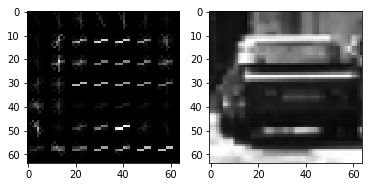

In [6]:
image = mpimg.imread('training_data/vehicles/KITTI_extracted/1.png')
f = HOGfeatures(image, params, debug=True)

## Color

In [8]:
def colorTransform(image, color):
    #make sure everything is scaled the same
    image = np.uint8(image*(255/np.max(image)))
    
    if color is 'RGB' or None:
        return image
    
    transform = eval('cv2.COLOR_RGB2' + color)
    return cv2.cvtColor(image, transform)

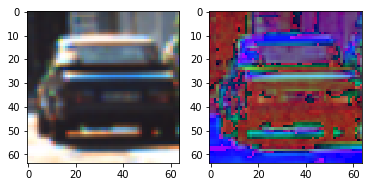

In [11]:
image = mpimg.imread('training_data/vehicles/KITTI_extracted/1.png')
displayImages([image, colorTransform(image, 'HSV')])

In [12]:
def spatialColorFeatures(image, params):
    features = cv2.resize(image, params.spatial_size).ravel() 
    return features

In [13]:
def histoColorFeatures(image, params):
    hist_features = []
    for i in range(image.shape[2]):
        channel_hist = np.histogram(image[:,:,i], bins=params.hist_bins, range=params.hist_range)
        hist_features = np.concatenate((hist_features, channel_hist[0])).astype(int)
    return hist_features

## Feature Extractor

In [14]:
def getFeaturesFromFiles(imageFiles, params, debug=False):
    
    features = []
    for imageFile in imageFiles:
        image = mpimg.imread(imageFile)
        
        features.append(getFeaturesFromImage(image, params, debug))
    return features

def getFeaturesFromImage(image, params, debug=False):
    image = colorTransform(image, params.colorSpace)

    spatial_features = spatialColorFeatures(image, params)
    hist_features = histoColorFeatures(image, params)
    HOG_features = HOGfeatures(image, params, debug=debug)
    HOG_features = ravelHOGfeatures(HOG_features, 0, 0)
    
    return np.concatenate((spatial_features, hist_features, HOG_features))

[array([114.,  41.,  43., ...,   0.,   0.,   0.])]

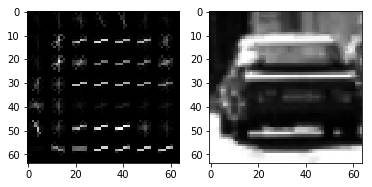

In [15]:
getFeaturesFromFiles(['training_data/vehicles/KITTI_extracted/1.png'], params, debug=True)

## Train Classifier

In [ ]:
#load a saved classifier
svc = joblib.load('HSVclassifier.pkl') 
X_scaler = joblib.load('HSVscaler.pkl')

In [22]:
#train a new classifier
carDirectories = getImageFilesFromDirectory(['training_data/vehicles'])
notCarDirectories = getImageFilesFromDirectory(['training_data/non-vehicles'])

cars = getImageFilesFromDirectory(carDirectories)
notCars = getImageFilesFromDirectory(notCarDirectories)

carFeatures = getFeaturesFromFiles(cars, params)
notCarFeatures = getFeaturesFromFiles(notCars, params)

X = np.vstack((carFeatures, notCarFeatures)).astype(np.float64)
y = np.hstack((np.ones(len(carFeatures)), np.zeros(len(notCarFeatures))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

In [23]:
svc = LinearSVC()
svc.fit(X_train, y_train)
accuracy_score(svc.predict(X_test), y_test)

0.9895833333333334

In [24]:
#save the classifier
joblib.dump(svc, 'HSVclassifier.pkl') 
joblib.dump(X_scaler, 'HSVscaler.pkl') 

['HSVscaler.pkl']

## Define the windows to look at

In [27]:
def draw_boxes(image, boxes, color=(0, 0, 255), thick=6):
    imagecopy = np.copy(image)
    for box in boxes:
        cv2.rectangle(imagecopy, (box[0][0], box[0][1]), (box[1][0], box[1][1]), color, thick)
    return imagecopy

def slide_window(imageShape, x_start_stop=[0, None], y_start_stop=[0, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    if x_start_stop[1] == None:
        x_start_stop[1] = imageShape[1]
    if y_start_stop[1] == None:
        y_start_stop[1] = imageShape[0]
        
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int(np.ceil((xspan-nx_buffer)/nx_pix_per_step)) 
    ny_windows = np.int(np.ceil((yspan-ny_buffer)/ny_pix_per_step)) 
    
    window_list = []
    
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append([(startx, starty), (endx, endy)])
    # Return the list of windows
    return window_list

In [ ]:
image = mpimg.imread('test_images/test1.jpg')

def getWindows(imageShape, debug=False):
    windowRanges = []
    windowRanges.append({'yRange' : [500,None],
                         'xy_window' : [256, 256],
                         'color' : (0, 0, 255)})
    windowRanges.append({'yRange' : [400,600],
                         'xy_window' : [128, 128],
                         'color' : (0, 255, 0)})
    windowRanges.append({'yRange' : [400,500],
                         'xy_window' : [64, 64],
                         'color' : (255, 0, 0)})

    windows = []

    for windowRange in windowRanges:
        boxes = slide_window(imageShape,
                             y_start_stop=windowRange['yRange'], 
                             xy_window=windowRange['xy_window'],
                             xy_overlap=(0.5, 0.5))
        if windows == []:
            windows = boxes
        else:
            windows = np.concatenate((windows, boxes))

        if debug:
            #visualize the size of the boxes
            boxes = slide_window(image,
                             y_start_stop=windowRange['yRange'], 
                             xy_window=windowRange['xy_window'],
                             xy_overlap=(0, 0))
            displayImages([draw_boxes(image, boxes, color=windowRange['color'])])
        
    return windows

image = mpimg.imread('test_images/test1.jpg')
allWindows = getWindows(image.shape, True)
displayImages([draw_boxes(image, allWindows)])

In [ ]:
def getCarBoxes(image, windows, scaler, params):
    carWindows = []
    for window in windows:
        if doesWindowContainCar(image, window, scaler, params):
            carWindows.append(window)
            
    return carWindows

def doesWindowContainCar(image, window, scaler, params, debug=False):
    imagePiece = cv2.resize(image[window[0][1]:window[1][1], window[0][0]:window[1][0]],
                              (64, 64))      
    if debug:
        displayImages([imagePiece])
    
    features = getFeaturesFromImage(imagePiece, params, debug=debug)
    features = scaler.transform(np.array(features).reshape(1, -1))

    return svc.predict(features) == 1


image = mpimg.imread('test_images/test1.jpg')
carBoxes = getCarBoxes(image, allWindows, X_scaler, params)
displayImages([draw_boxes(image, carBoxes)])

## Improved window searching (only compute HOG once)

In [73]:
def getImageToSearch(image, ystart, ystop, scale, color):
    image = image.astype(np.float32)/255
    
    img_tosearch = image[ystart:ystop,:,:]
    img_tosearch = colorTransform(img_tosearch, color)
    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    return img_tosearch

def find_cars(img, ystart, ystop, scale, svc, X_scaler, params, debug = False):
    
    draw_img = np.copy(img)
    img_tosearch = getImageToSearch(img, ystart, ystop, scale, params.colorSpace)

    # Define blocks and steps as above
    nxblocks = (img_tosearch.shape[1] // params.pix_per_cell) - params.cell_per_block + 1
    nyblocks = (img_tosearch.shape[0] // params.pix_per_cell) - params.cell_per_block + 1 
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // params.pix_per_cell) - params.cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    all_hog = HOGfeatures(img_tosearch, params, debug=False)
    allWindows = []
    windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_features = ravelHOGfeatures(all_hog, xpos, ypos, nblocks_per_window, nblocks_per_window)

            xleft = xpos*params.pix_per_cell
            ytop = ypos*params.pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(img_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = spatialColorFeatures(subimg, params)
            hist_features = histoColorFeatures(subimg, params)

            # Scale features and make a prediction
            test_features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_features = X_scaler.transform(test_features)    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            #put window into original scalse
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            original_window = [[xbox_left, ytop_draw+ystart],[xbox_left+win_draw,ytop_draw+win_draw+ystart]]
            
            if yb%4 is 0 and xb%4 is 0:
                allWindows.append(original_window)
            
            if test_prediction == 1:
                cv2.rectangle(draw_img,(original_window[0][0],original_window[0][1]),(original_window[1][0],original_window[1][1]),(0,0,255),6) 
                windows.append(original_window)
                
    if debug:
        displayImages([draw_boxes(img, allWindows)])
        displayImages([draw_img])
        
                
    return windows

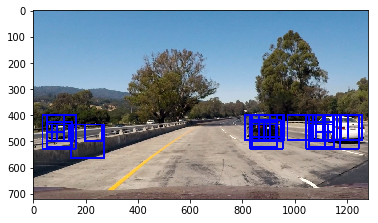

In [80]:
searches = []
searches.append({'scale' : 1,
                     'ystart' : 400,
                     'ystop' : 520})
searches.append({'scale' : 1.5,
                     'ystart' : 400,
                     'ystop' : 620})
searches.append({'scale' : 2,
                     'ystart' : 400,
                     'ystop' : 720})
searches.append({'scale' : 2.5,
                     'ystart' : 400,
                     'ystop' : 720})

#searches = [{'scale' : 1.2, 'ystart' : 400, 'ystop' : 720}]

image = mpimg.imread('test_images/test1.jpg')
windows = []
allWindows = []
for search in searches:
    windows = find_cars(image, search['ystart'], search['ystop'], search['scale'],
                                                 svc, X_scaler, params, debug=False)
    
    if len(allWindows) is 0:
        allWindows = windows
    elif len(windows) > 0:
        allWindows = np.concatenate((allWindows, windows), axis=0)
        
    
displayImages([draw_boxes(image, allWindows)])

NameError: name 'doesWindowContainCar' is not defined

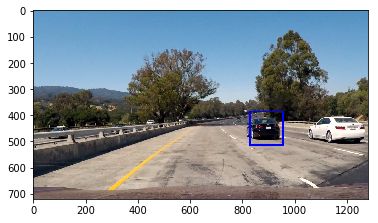

In [81]:
window = [(828, 386), (956, 514)]
displayImages([draw_boxes(image, [window])])

print(doesWindowContainCar(image, window, X_scaler, params, debug=True))

## Heat map

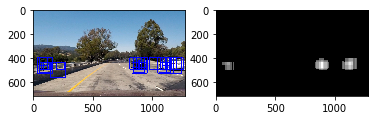

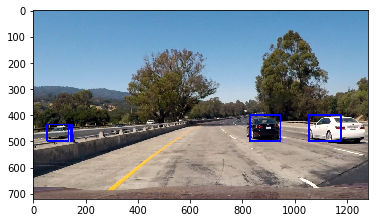

In [88]:
def add_heat(heatmap, boxes):
    for box in boxes:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def getHeatMap(image, carBoxes, threshold):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,carBoxes)
    
    heat = apply_threshold(heat,threshold)
  
    heatmap = np.clip(heat, 0, 255)
    return heatmap

def draw_labeled_bboxes(image, labels):
    for car_number in range(1, labels[1]+1):
        
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        boundingBox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        cv2.rectangle(image, boundingBox[0], boundingBox[1], (0,0,255), 6)
    
    return image

def drawCarBoxes(image, carBoxes, threshold=1, debug=False):
    heatMap = getHeatMap(image, carBoxes, threshold)
    if debug:
        displayImages([draw_boxes(image, carBoxes), heatMap])
    labels = label(heatMap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img


image = mpimg.imread('test_images/test1.jpg')
image = drawCarBoxes(image, allWindows, threshold=3, debug=True)
displayImages([image])

## Video Pipeline

In [ ]:
allWindows = getWindows((720, 1280))

def imagePipeline(image):
    carBoxes = getCarBoxes(image, allWindows, X_scaler, params)
    allFrameBoxes.append(carBoxes)
    
    lastTenFrames = np.concatenate(allFrameBoxes[-10:])
    image  = drawCarBoxes(image, carBoxes)#, threshold=min(10,len(allFrameBoxes)))
    return image
    

In [ ]:
allFrameBoxes = []

videoOutput = 'output_images/test_video.mp4'
clip = VideoFileClip('test_video.mp4')
videoWithBoxes = clip.fl_image(imagePipeline)
%time videoWithBoxes.write_videofile(videoOutput, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(videoOutput))